# **Отток клиентов**

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

# **Подготовка данных**

In [ ]:
pip install skimpy

     |████████████████████████████████| 12.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 59.5 MB/s eta 0:00:01
     |████████████████████████████████| 150 kB 68.1 MB/s eta 0:00:01
     |████████████████████████████████| 237 kB 84.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 744 kB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 47.2 MB/s eta 0:00:01
     |████████████████████████████████| 282 kB 45.2 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 4.0 MB/s  eta 0:00:01
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.7.1
    Uninstalling jupyter-core-4.7.1:
      Successfully un

In [ ]:
# Импортирую библиотеки
import pandas as pd
from skimpy import clean_columns
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
import itertools
import operator
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Откроем наши DataFrame и результат выведем на экран. Таблицу Churn мы сохраним в data:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [ ]:
data.shape
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В данном датасете 13 признако, целевой признак, 10000 строк.

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента

In [ ]:
# Сделаем сразу замену типа у признака Exited на uint8, т.к. данный тип является стандартным для цифровых булевых значений в pandas.
data['Exited'] = data['Exited'].astype('uint8')

In [ ]:
# Приведем название всех столбцов к единому регистру и стилю
data = clean_columns(data)
data.head()

14 column names have been cleaned

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
# Проверим датафрейм на дубликаты
data.duplicated().sum()

0

In [ ]:
# Дубликатов нет, при рассмотрении информации о датафрейма были замечены признаки пропусков в столбце 'tenure'
data.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [ ]:
# Сделаем замену пропущенных значений на "0", аргументация в выводе
data['tenure'].fillna('0', inplace=True)
data['tenure'] = data['tenure'].astype('int64')
data.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [ ]:
# Удаляем данные не имеющие значения для модели обучения
data = data.drop(['surname', 'row_number', 'customer_id'], axis=1)
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Применение демми-признаков (ohe)
data = pd.get_dummies(data, drop_first = True)
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## **Сформируем выборки**

Обучающая - 60%

Валидационная - 20%

Тестовая - 20%

In [ ]:
# Разделим на признаки и целевой признак
features = data.drop('exited', axis=1)
target = data['exited']

In [ ]:
# Валидационная 60%
features_train, features_validtest, target_train, target_validtest = train_test_split(features,
                                                    target,
                                                    train_size=0.6,
                                                    random_state=12345,
                                                    stratify=target)

In [ ]:
# Валидационная и тестовая соответственно поровну по 20% от общей
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest,
                                                    train_size=0.5,
                                                    random_state=12345,
                                                    stratify=target_validtest)

In [ ]:
print('Проверка размера выборок:')
print('Обучающая:')
print('features_train', features_train.shape)
print('target_train', target_train.shape)
print('Валидационная:')
print('features_valid', features_valid.shape)
print('target_valid', target_valid.shape)
print('Тестовая:')
print('features_test', features_test.shape)
print('target_test', target_test.shape)

Проверка размера выборок:
Обучающая:
features_train (6000, 11)
target_train (6000,)
Валидационная:
features_valid (2000, 11)
target_valid (2000,)
Тестовая:
features_test (2000, 11)
target_test (2000,)


### **Созданные выборки:**

**Обучающая**

features_train, target_train

**Валидационная**

features_valid, target_valid

**Тестовая**

features_test, target_test

In [ ]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,549,49,6,124829.16,1,0,1,93551.36,1,0,0
9925,694,38,0,195926.39,1,1,1,85522.84,0,0,0
8746,660,34,8,106486.66,2,0,1,182262.66,0,0,1
660,632,41,0,81877.38,1,1,1,33642.21,1,0,0
3610,580,56,1,131368.30,1,1,0,106918.67,0,0,0


In [ ]:
#Для масштабирования методом scaler зафиксируем численные признаки
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [ ]:
# Масштабируем числ признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.467449,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.461501,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.110432,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-1.461501,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.140009,0.879129,-0.914708,1,0,0.113236,0,0,0


In [ ]:
# Масштабируем численные признаки валидационной выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6612,-1.524838,2.383160,-0.497026,1.011655,-0.914708,0,1,0.010275,0,0,0
519,0.587990,1.811221,0.467449,0.213192,-0.914708,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,1.110432,0.893896,-0.914708,1,0,-0.603508,0,0,0
3475,1.226991,-0.762506,-0.175534,-0.240363,0.820981,1,1,-1.621460,0,0,1
2707,-0.133464,-0.095244,-0.497026,0.447305,-0.914708,0,0,0.338574,0,0,0


In [ ]:
# Масштабируем численные признаки тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
657,-0.504497,1.429928,-1.140009,0.873883,0.820981,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,-1.140009,-1.219673,-0.914708,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,-1.140009,-1.219673,-0.914708,1,0,-1.374743,0,0,1
1551,0.825039,1.239281,0.788940,-1.219673,0.820981,0,1,0.382306,0,1,0
2344,0.660135,0.953312,-0.175534,0.267087,-0.914708,1,0,-1.613578,1,0,0


## **Применение модели машинного обучения**

В результате мы получили масштабированные признаки для трех выборок. Перейдем к обучению моделей.

In [ ]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=12345)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)

    model_RFC = RandomForestClassifier(max_depth=10, n_estimators=50, min_samples_leaf=5, random_state=12345)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)

    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистческая регрессия", LgR_score)

In [ ]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.79 случайный лес  0.866 логистческая регрессия 0.811


## **Исследование баланса классов выборки**

In [ ]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: exited, dtype: float64

<AxesSubplot:title={'center':'Соотношение тех, кто остался и тех кто ушел'}>

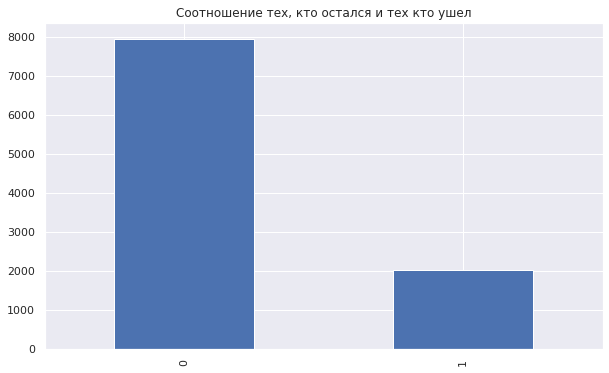

In [ ]:
# Построим диаграмму баланса классов
data['exited'].value_counts().plot(kind='bar', grid=True, figsize=(10,6), title='Соотношение тех, кто остался и тех кто ушел')

Как мы выяснили в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. С уверенностью можем сказать что имеется дисбаланс.

## **Проверка адекватности**

### **Проверим качество моделей до борьбы с дисбалансом**

In [ ]:
# Заранее напишем функцию для изучия полноты, точности и F1-меры
def main_param(target_valid, prediction):
    '''
    Функция для вывода основных метрик
    '''
    print('confusion_matrix\n',confusion_matrix(target_valid, prediction))
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))

In [ ]:
# Функция для отображения соотношения ответов моделей (сколько 0, сколько 1)
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=12345)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)


    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)

    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)

    print("Доли ответов:" "Дерево решений", DTC_share, "Случайный лес ", RFC_share, "Логистческая регрессия", LgR_share , end='')

In [ ]:
# Применим функцию отображения соотношения ответов моделей
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:Дерево решений 0    0.78
1    0.22
dtype: float64 Случайный лес  0    0.8665
1    0.1335
dtype: float64 Логистческая регрессия 0    0.931
1    0.069
dtype: float64

Логистичесая регрессия показывала самую высокую точность, далее случайный лес и в конце дерево решений

С учетом дисбаланса результата неудивительно что модели с большой вероятностью будут выдавать ответ 0, построим матрицы ошибок для моделей

### **Случайный лес**

In [ ]:
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
main_param(target_valid, RFC_prediction)

confusion_matrix
 [[1531   61]
 [ 202  206]]
Полнота 0.5049019607843137
Точность 0.7715355805243446
F1-мера 0.6103703703703703


<div class="alert alert-success">
<b>Комментарий ревьюера v2✔️:</b>

Вот это конечно повезло)
</div>

In [ ]:
# Расчет roc_auc_RFC
RFC_probabilities_one_valid = model_RFC.predict_proba(features_valid)[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, RFC_probabilities_one_valid)

auc_roc_RFC

0.8665770642427826


**Вывод:**

Случайный лес примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP). Точность и качество также низкое.

### **Дерево решений**

In [ ]:
# Матрица ошибок для дерево решений
model_DTC = DecisionTreeClassifier(random_state=12345)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
main_param(target_valid, DTC_prediction)

confusion_matrix
 [[1366  226]
 [ 194  214]]
Полнота 0.5245098039215687
Точность 0.4863636363636364
F1-мера 0.5047169811320754


**Вывод:**

Матрица показала, что дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP).

In [ ]:
# Расчет roc_auc_DTC
DTC_probabilities_one_valid = model_DTC.predict_proba(features_valid)[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, DTC_probabilities_one_valid)

auc_roc_DTC

0.6912750024632969

**Вывод:**

Видим низкое значение F1, следовательно низкое качество модели, проблема в точности.

### **Логистическая регрессия**

In [ ]:
# Матрица ошибок для логистической регрессии
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
main_param(target_valid, LgR_prediction)

confusion_matrix
 [[1538   54]
 [ 324   84]]
Полнота 0.20588235294117646
Точность 0.6086956521739131
F1-мера 0.3076923076923077


In [ ]:
# Для логистической регрессии расчитаем метрику AUC-ROC
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.787586831214898

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

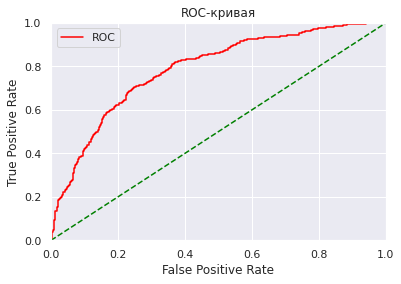

In [ ]:
fper, tper, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid)
plot_roc_curve(fper, tper)

Score 0.7325
AUC-ROC 0.7937758646172037


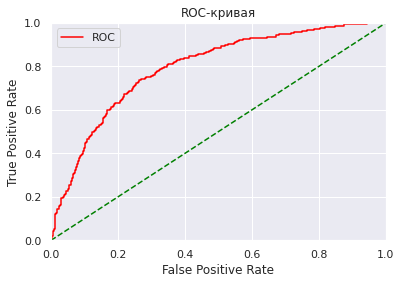

In [ ]:
# Попробуем обучать логистическую регресию сбалансировав классы
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LgR_probabilities_one_valid_class_weight))

fper, tper, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight)
plot_roc_curve(fper, tper)

**Вывод:**

Отстутсвие улучшений - тоже результат. Высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

## **Борьба с дисбалансом**

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%. Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса. Либо же уменьшить кол-во отрицтаельных ответов.

- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.
- Обучим новые модели

In [ ]:
# Создадим функцию для увеличения представленной класса в выборке
def upsample(features, target, repeat, upsampled_сlass):
    """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float),
    класс который будет увеличен (upsampled_сlass (0 or 1))"""
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0



    return features_upsampled, target_upsampled

In [ ]:
# Создадим функцию для уменьшения представленной класса в выборке
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [ ]:
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, fraction=0.25)

In [ ]:
# Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.939904
1    0.060096
Name: exited, dtype: float64
(20334,)


In [ ]:
# Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

In [ ]:
# Применим функцию upsample
# увеличим количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: exited, dtype: float64
(9666,)


In [ ]:
# Применим функцию downsample
# Уменьшим кол-в пооложительных ответов в 4 раза
# Протестируем функцию (верное значение)
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.2)
print(target_downsampled_train.value_counts(normalize = 0))
print(target_downsampled_train.shape)

1    1222
0     956
Name: exited, dtype: int64
(2178,)


<div class="alert alert-success">
<b>Комментарий ревьюера v2✔️:</b>

Ты выше сделал 0.25 и это было верно.
</div>

<AxesSubplot:ylabel='Frequency'>

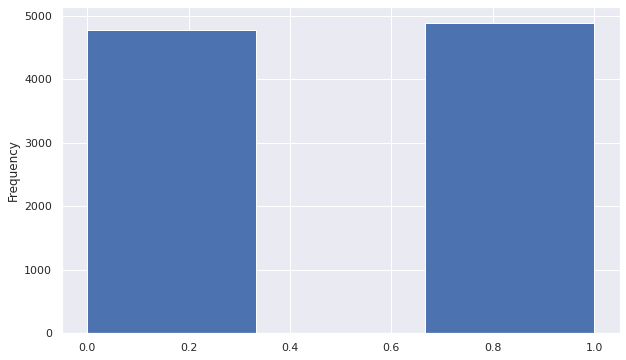

In [ ]:
# Ну почти идеально и выигрышнее выглядит upsample с ним и будем работать
target_train_upsampled.plot(kind='hist', bins=3, figsize=(10,6))

## **Обучение моделей на сбалансированной выборке**

In [ ]:
# Точность моделей на выборке с дисбалансом
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.79 случайный лес  0.866 логистческая регрессия 0.811


In [ ]:
# Точность моделей на сбалансированной выборке
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.801 случайный лес  0.829 логистческая регрессия 0.7255


**Вывод:**

Точность сильно не изменилась. Проверим качество ответов.

In [ ]:
# Решающее дерево
model_DTC_upsampled = DecisionTreeClassifier(random_state=12345)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
main_param(target_valid, DTC_prediction_upsampled)

confusion_matrix
 [[1394  198]
 [ 200  208]]
Полнота 0.5098039215686274
Точность 0.5123152709359606
F1-мера 0.5110565110565111


In [ ]:
# Расчитаем auc_roc для DTC на сбалансированной выборке
DTC_upsampled_valid = model_DTC_upsampled.predict_proba(features_valid)[:, 1]

auc_roc_DTC = roc_auc_score(target_valid, DTC_upsampled_valid)

auc_roc_DTC

0.6927160311360725

In [ ]:
# Случайный лес
model_RFC_upsampled = RandomForestClassifier(max_depth=10, n_estimators=50, min_samples_leaf=5, random_state=12345)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
main_param(target_valid, RFC_prediction_upsampled)

confusion_matrix
 [[1365  227]
 [ 115  293]]
Полнота 0.7181372549019608
Точность 0.5634615384615385
F1-мера 0.6314655172413793


In [ ]:
# Расчитаем auc_roc для RFC на сбалансированной выборке
RFC_upsampled_valid = model_RFC_upsampled.predict_proba(features_valid)[:, 1]

auc_roc_RFC = roc_auc_score(target_valid, RFC_upsampled_valid)

auc_roc_RFC

0.8734358064833975

In [ ]:
# Логистическая регрессия
model_LgR_upsampled = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
main_param(target_valid, LgR_prediction_upsampled)

confusion_matrix
 [[1163  429]
 [ 107  301]]
Полнота 0.7377450980392157
Точность 0.4123287671232877
F1-мера 0.5289982425307558


In [ ]:
# Расчитаем auc_roc для LgR на сбалансированной выборке
LgR_upsampled_valid = model_LgR_upsampled.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_upsampled_valid)

auc_roc_LgR

0.7937666272539168

**Вывод:**

Показаели всех моделей улучшились.

Лучшие результаты показывает алгоритм случайный лес (RandomForestClassifier). На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.63, что выше целевого целевого значения.

# **Тестирование модели**

In [ ]:
# Обучим финальную модель
model_RFC_final = RandomForestClassifier(
    #bootstrap = True, class_weight = 'balanced', max_depth= 10,  n_estimators = 50, random_state=12345)
    bootstrap = True, max_depth= 10,  n_estimators = 50, random_state=12345)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=12345)

In [ ]:
model_RFC_final_prediction = model_RFC_final.predict(features_test)
main_param(target_test, model_RFC_final_prediction)

confusion_matrix
 [[1372  221]
 [ 139  268]]
Полнота 0.6584766584766585
Точность 0.5480572597137015
F1-мера 0.5982142857142857


In [ ]:
# Расчитаем auc_roc для RFC на тестовой выборке
model_RFC_final_valid = model_RFC_final.predict_proba(features_test)[:, 1]

auc_roc_RFC = roc_auc_score(target_test, model_RFC_final_valid)

auc_roc_RFC

0.8512472410777495

In [ ]:
# Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [ ]:
# Сравним показатель точности (accuracy_score) константной модели и финальной
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_test, model_RFC_final_prediction))
# Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_test, model_RFC_final_valid))

accuracy_score константой модели: 0.796
accuracy_score финальной модели: 0.82
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.8512472410777495


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

**Выводы:**

В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности и полноты.

Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классо в обучеющей выборки: 0 - 0.50569 1 - 0.49431

Разобрали несколько вариантов борьбы с дисбалансом upsampling и downsampling

На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса:

- Полнота 0.7181372549019608
- Точность 0.5634615384615385
- F1-мера 0.6314655172413793
- AUC-ROC 0.8734358064833975

Финальная модель прошла проверку на адекватность в сравнении с контантной моделью: accuracy_score константой модели: 0.796

- accuracy_score константой модели: 0.796
- accuracy_score финальной модели: 0.82
- AUC-ROC константой модели: 0.5
- AUC-ROC финальной модели: 0.8512472410777495
